# Problem Statement

The objective is to predict the 5-Year Career Longevity for NBA Rookies. The following are the rookie year statistics that will be used to predict whether or not a player lasts 5 years in the league: 'Year Drafted', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',  'TARGET_5Yrs'.

<h1>Objective</h1>

Analyse the dataset and predict whether or not a player lasts 5 years in the rookie league by using Machine Learning.

<h2>PART A</h2>

### Import the required libraries and dataset

Let's start with importing the relevant modules. We will read the dataset and try to understand the data.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from imblearn.over_sampling import BorderlineSMOTE,SMOTE
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, recall_score
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

#### Read the CSV file

In [ ]:
# loading the dataset into our notebook
data = pd.read_csv("nba_logreg.csv")

## Data Visualization and Exploration 


The purpose of this EDA is to find insights in the data which will serve us later for data preparation and transformation.

### Printing 2 rows to identify all the features present in the dataset

In [ ]:
data.head(2)

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,NaN,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0
1,Andrew Harrison,35.0,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0


In [ ]:
data.columns

Index(['Name', 'GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made', '3PA',
       '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK',
       'TOV', 'TARGET_5Yrs'],
      dtype='object')

 ### Description and Basic statistical details

We will look into the data desciption and data types to understand more about the data

In [ ]:
data.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,1331.000000,1336.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1329.000000,1340.000000,1340.000000,1328.000000,1336.00000,1340.000000,1340.000000,1337.000000,1337.000000,1340.000000,1340.000000,1340.000000
mean,60.417731,17.612126,6.801493,2.629104,5.885299,44.169403,0.247612,0.779179,19.308126,1.297687,1.821940,70.252334,1.00988,2.025746,3.034478,1.553179,0.618399,0.368582,1.193582,0.620149
std,17.428301,8.307959,4.357545,1.683555,3.593488,6.137679,0.383688,1.061847,16.022916,0.987246,1.322984,10.592506,0.77794,1.360008,2.057774,1.471742,0.410042,0.429049,0.722541,0.485531
min,11.000000,3.100000,0.700000,0.300000,0.800000,23.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,47.000000,10.800000,3.700000,1.400000,3.300000,40.200000,0.000000,0.000000,0.000000,0.600000,0.900000,64.600000,0.40000,1.000000,1.500000,0.600000,0.300000,0.100000,0.700000,0.000000
50%,63.000000,16.100000,5.550000,2.100000,4.800000,44.100000,0.100000,0.300000,22.400000,1.000000,1.500000,71.200000,0.80000,1.700000,2.500000,1.100000,0.500000,0.200000,1.000000,1.000000
75%,77.000000,22.825000,8.800000,3.400000,7.500000,47.900000,0.400000,1.200000,32.500000,1.600000,2.300000,77.600000,1.40000,2.600000,4.000000,2.000000,0.800000,0.500000,1.500000,1.000000
max,82.000000,40.900000,28.200000,10.200000,19.800000,73.700000,2.300000,6.500000,100.000000,7.700000,10.200000,100.000000,5.30000,9.600000,13.900000,10.600000,2.500000,3.900000,4.400000,1.000000


**Observation:**
1. Avarage game played is 60.4 with a standard deviation of 17.4, i.e majority of the games playes in  given dataset lies in range 43 to 77.8.
2. Minimum games playes in the given dataset is 11  and maximum games played is 82.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         1340 non-null   object 
 1   GP           1331 non-null   float64
 2   MIN          1336 non-null   float64
 3   PTS          1340 non-null   float64
 4   FGM          1340 non-null   float64
 5   FGA          1340 non-null   float64
 6   FG%          1340 non-null   float64
 7   3P Made      1340 non-null   float64
 8   3PA          1340 non-null   float64
 9   3P%          1329 non-null   float64
 10  FTM          1340 non-null   float64
 11  FTA          1340 non-null   float64
 12  FT%          1328 non-null   float64
 13  OREB         1336 non-null   float64
 14  DREB         1340 non-null   float64
 15  REB          1340 non-null   float64
 16  AST          1337 non-null   float64
 17  STL          1337 non-null   float64
 18  BLK          1340 non-null   float64
 19  TOV   

The dataset provides the NBA players' career longevity information. It includes 1340 records and 21 fields.

**Observation:**

-The given dataset has non-null feature columns of object, int64 and float64 datatypes.

### Printing the class label count  & Visualization

#### TARGET_5Yrs — Career length is greater than 5 years ? (binary: “1”, means “Yes”, “0” means “No”)

In [ ]:
data["TARGET_5Yrs"].value_counts()

1    831
0    509
Name: TARGET_5Yrs, dtype: int64

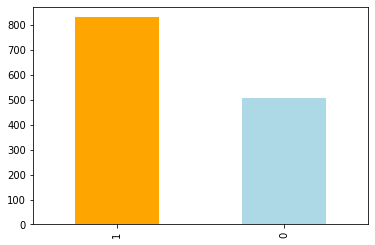

In [ ]:
data["TARGET_5Yrs"].value_counts().plot(kind="bar",color=["Orange", "lightBlue"])
plt.show()

In [ ]:
count_no_sub = len(data[data['TARGET_5Yrs']==0])
count_sub = len(data[data['TARGET_5Yrs']==1])
pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
print("percentage of nba rookies career less than 5 years", pct_of_no_sub*100)
pct_of_sub = count_sub/(count_no_sub+count_sub)
print("percentage of nba rookies career greater than 5 years", pct_of_sub*100)

percentage of nba rookies career less than 5 years 37.985074626865675
percentage of nba rookies career greater than 5 years 62.01492537313433


Our classes are imbalanced, and the ratio of less than 5 years to more than 5 years instances is 37:62. Before we go ahead to balance the classes, let’s do some more exploration.

In [ ]:
data.groupby('TARGET_5Yrs').mean()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
TARGET_5Yrs,,,,,,,,,,,,,,,,,,,
0,51.675889,14.252259,5.042829,1.946169,4.542043,42.388802,0.229666,0.754617,19.378131,0.923379,1.321611,68.754762,0.717228,1.531238,2.247544,1.224655,0.498232,0.253438,0.942240
1,65.779394,19.680048,7.878700,3.047413,6.708063,45.260048,0.258604,0.794224,19.265496,1.526955,2.128400,71.168325,1.187726,2.328640,3.516486,1.753855,0.692271,0.439110,1.347533


#### Obesrvations:

-The games playes by nba rookies whose carrer is less than 5 years is less than the nba rookies whose carrer length is more than 5 years

In [ ]:
#list of numerical columns
Target=data['TARGET_5Yrs']
num_cols=['GP', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%', '3P Made','3PA','3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 
          'REB', 'AST','STL', 'BLK','TOV']

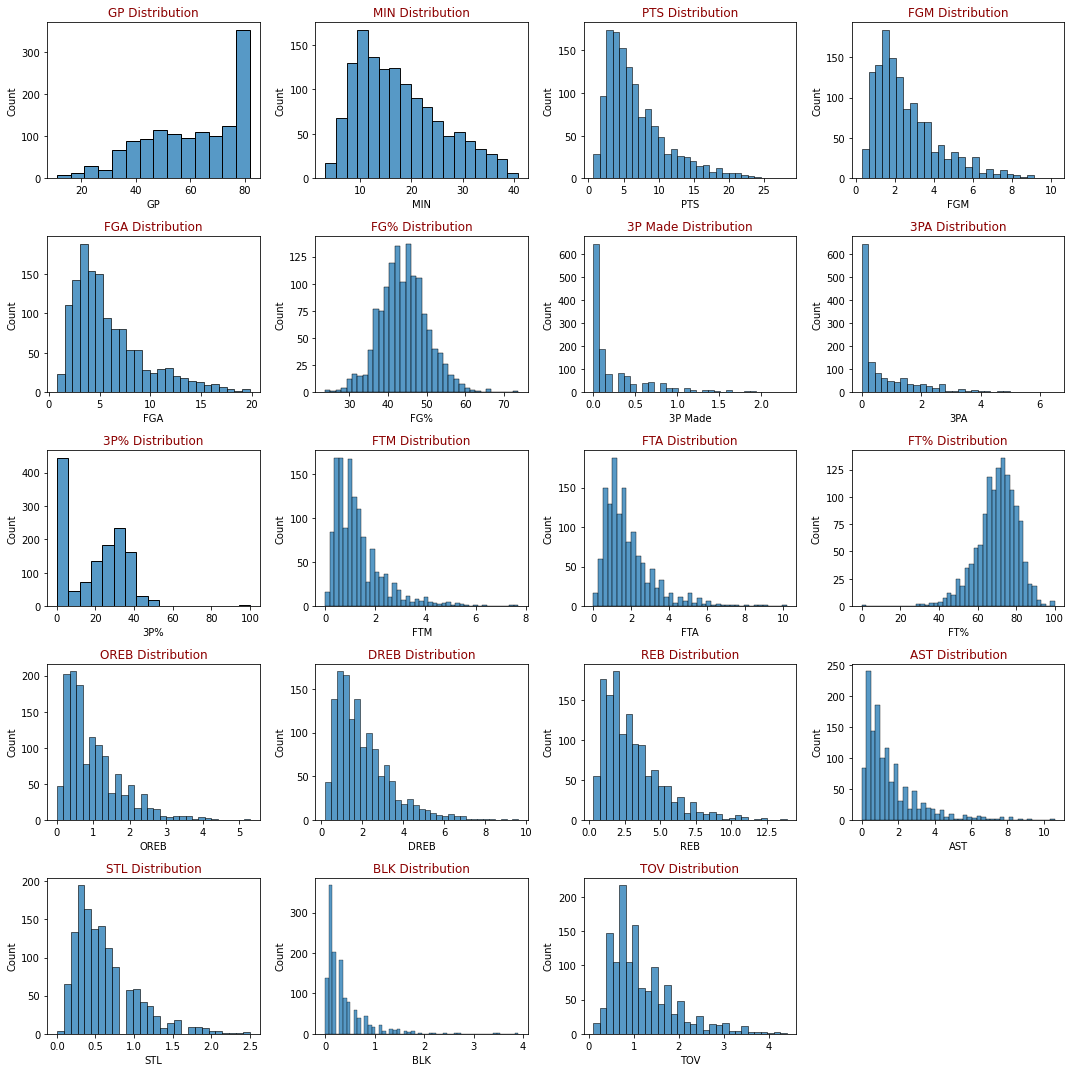

In [ ]:
#Visualizing distribution of all features
def draw_histograms(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(15,15))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        sns.histplot(dataframe[feature],ax=ax)
        ax.set_title(feature+" Distribution",color='DarkRed')
        
    fig.tight_layout()  
    plt.show()
draw_histograms(data,num_cols,5,4)

#### Based on the above histogram we can see the data is highly skewed. We will be doing further visualization of the dataset.

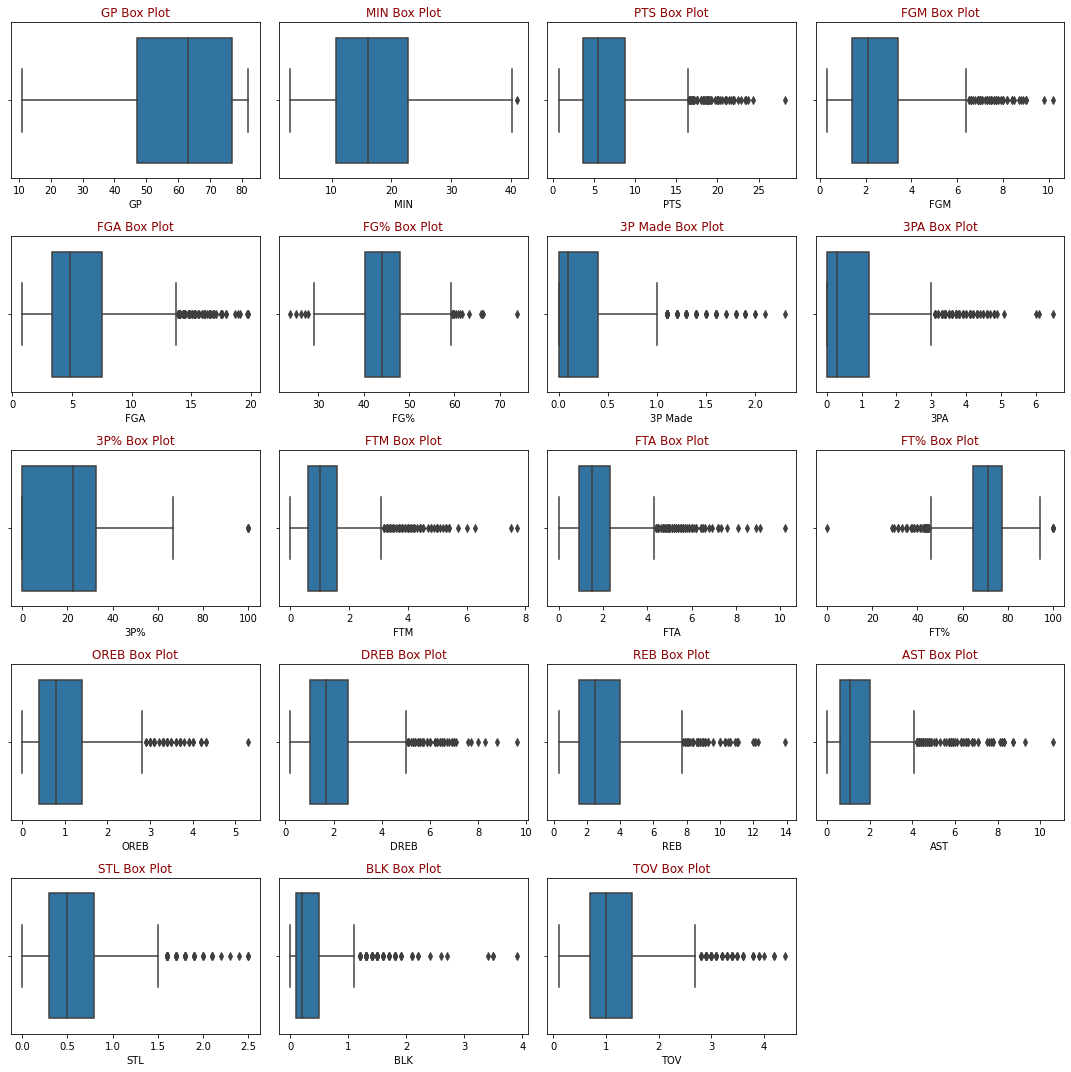

In [ ]:
#Visualizing box plot of features
def draw_box(dataframe, features, rows, cols):
    fig=plt.figure(figsize=(15,15))
    for i, feature in enumerate(features):
        ax=fig.add_subplot(rows,cols,i+1)
        sns.boxplot(x=feature,data=data)
        ax.set_title(feature+" Box Plot",color='DarkRed')
        
    fig.tight_layout()  
    plt.show()
draw_box(data,num_cols,5,4)

From the above visualizations it is clear that we have few outliers present in the data. The histograms shows there are skewness present in the features which needs to be removed.

Apart from games played, all the other attributes are having outliers.

### Data Pre-Processing and Cleaning

We will pre-process the data and prepare it for training the model. 
We will start the preprocessing by cleaning our data. 
For this we will first check for null values in the data.

#### Checking NULL values

In [ ]:
data.isnull().sum()

Name            0
GP              9
MIN             4
PTS             0
FGM             0
FGA             0
FG%             0
3P Made         0
3PA             0
3P%            11
FTM             0
FTA             0
FT%            12
OREB            4
DREB            0
REB             0
AST             3
STL             3
BLK             0
TOV             0
TARGET_5Yrs     0
dtype: int64

There are null values present in GP, MIN, 3P%, FT%, OREB, AST, STL. Among them Games Playes is distinct value so we will replace the missing values of this column with median. Rest of the missing values we will replace with mean values.

In [ ]:
data['MIN'] = data['MIN'].fillna(data['MIN'].mean())
data['3P%'] = data['3P%'].fillna(data['3P%'].mean())
data['FT%'] = data['FT%'].fillna(data['FT%'].mean())
data['OREB'] = data['OREB'].fillna(data['OREB'].mean())
data['AST'] = data['AST'].fillna(data['AST'].mean())
data['STL'] = data['STL'].fillna(data['STL'].mean())

In [ ]:
data['GP'] = data['GP'].fillna(data['GP'].median())

In [ ]:
#Varifying if there is any more null values left
data.isnull().sum()

Name           0
GP             0
MIN            0
PTS            0
FGM            0
FGA            0
FG%            0
3P Made        0
3PA            0
3P%            0
FTM            0
FTA            0
FT%            0
OREB           0
DREB           0
REB            0
AST            0
STL            0
BLK            0
TOV            0
TARGET_5Yrs    0
dtype: int64

### Feature Engineering 

We will drop the unneccessary columns from the dataset and separate the target feature from the data

In [ ]:
data.drop('Name',axis = 1,inplace = True)
data.drop('TARGET_5Yrs',axis = 1,inplace = True)


In [ ]:
#resetting the index
data.reset_index(drop=True, inplace=True)
data.head()

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV
0,63.0,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,1.6,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3
1,35.0,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,2.6,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6
2,74.0,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,0.9,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0
3,58.0,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,0.9,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0
4,48.0,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,1.3,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8


Identifying the top 12 features for the dataset showing the importance with the class variable.

In [ ]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(data,Target)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(data.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
#naming the dataframe columns
featureScores.columns = ['Specs','Score'] 
bestfeature_columns = featureScores.nlargest(12,'Score')
#print 12 best features
print(bestfeature_columns) 

   Specs        Score
0     GP  1026.162403
1    MIN   526.082434
2    PTS   373.235386
4    FGA   251.634496
14   REB   167.499527
3    FGM   145.603935
10   FTA   112.771481
13  DREB    99.079570
9    FTM    88.615268
12  OREB    68.517799
5    FG%    58.916027
15   AST    56.586714


#### Correlational Analysis 

In [ ]:
#get correlations of each features in dataset
corr_matrix = data.corr()
corrPairs = corr_matrix.unstack()
ordPairs = corrPairs.sort_values(kind="quicksort").drop_duplicates()
positivePairs = ordPairs[ordPairs >0.8 ]
positivePairs = positivePairs[ordPairs <1 ]
print(positivePairs)

TOV   FTM        0.804990
FGA   FTA        0.805559
TOV   MIN        0.823279
FTM   FGA        0.826616
TOV   FGM        0.834352
DREB  OREB       0.837771
FTA   FGM        0.840408
FGA   TOV        0.845989
FTM   FGM        0.848019
PTS   TOV        0.850366
      FTA        0.880703
      FTM        0.896297
MIN   FGM        0.900580
FGA   MIN        0.908012
PTS   MIN        0.909471
OREB  REB        0.931994
REB   DREB       0.978177
FGA   PTS        0.979733
FGM   FGA        0.980050
FTM   FTA        0.980505
3PA   3P Made    0.982616
PTS   FGM        0.990834
dtype: float64


The above pairwise data shows we have highly correlated features in our dataset. We will plot a heatmap to visualize the correlation in the dataset.


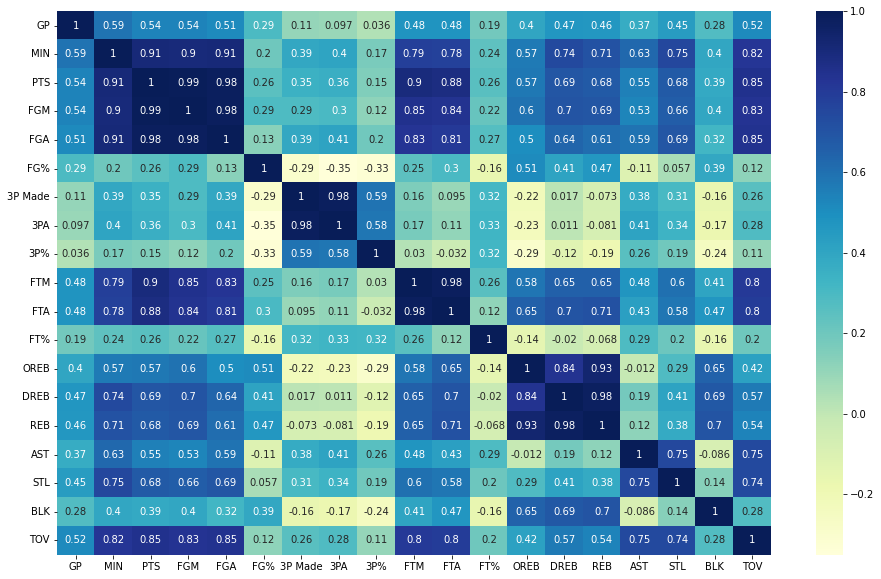

In [ ]:
#correlation matrix heatmap
plt.rcParams["figure.figsize"]=16,10
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.show()

To deal with highly correlated features we will transform the dataset. We will do principle component analysis and find the principle components.

In [ ]:
#Scalling the data for doing PCA
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [ ]:
from sklearn.decomposition import PCA
#cheking the number of principle coponents with 95% data
pca = PCA(n_components = 0.95,svd_solver = 'full')
pca.fit(scaled_data)
pca_df=pd.DataFrame(pca.transform(scaled_data))
pca_df.head()

,0,1,2,3,4,5,6,7,8
0,0.227159,0.188431,0.065438,-0.158029,0.065968,-0.010491,-0.211907,0.019314,-0.011164
1,0.178225,0.474376,0.377147,0.155528,0.174692,0.024473,-0.212897,-0.062765,0.168795
2,-0.097304,0.135437,-0.217954,-0.136562,0.036852,-0.036133,-0.025697,0.068358,0.017711
3,-0.217447,0.011651,-0.040335,0.049766,-0.079379,0.007165,0.016448,0.041584,-0.070760
4,-0.348044,-0.244492,0.089596,0.024837,0.007221,-0.127234,0.111543,-0.031657,0.087389


We found that there are 8 principle components which explains 95% of the data. So we will be taking all 8 componets and will create columns with them.

In [ ]:
pca_df.index=data.index
pca_df.columns=["PC1","PC2",'PC3','PC4','PC5','PC6','PC7','PC8','PC9']
#'PC10','PC11','PC12','PC13']
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,0.227159,0.188431,0.065438,-0.158029,0.065968,-0.010491,-0.211907,0.019314,-0.011164
1,0.178225,0.474376,0.377147,0.155528,0.174692,0.024473,-0.212897,-0.062765,0.168795
2,-0.097304,0.135437,-0.217954,-0.136562,0.036852,-0.036133,-0.025697,0.068358,0.017711
3,-0.217447,0.011651,-0.040335,0.049766,-0.079379,0.007165,0.016448,0.041584,-0.070760
4,-0.348044,-0.244492,0.089596,0.024837,0.007221,-0.127234,0.111543,-0.031657,0.087389


In [ ]:
pca_df.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
count,1.340000e+03,1.340000e+03,1.340000e+03,1.340000e+03,1.340000e+03,1.340000e+03,1.340000e+03,1.340000e+03,1.340000e+03
mean,-1.549341e-17,-6.781474e-17,-2.252551e-18,-3.511391e-17,-1.516783e-17,-4.313506e-17,5.792423e-17,8.254177e-18,4.926744e-17
std,5.159746e-01,2.960416e-01,1.931981e-01,1.653866e-01,1.191825e-01,1.137191e-01,9.912502e-02,9.085755e-02,8.100285e-02
min,-9.647320e-01,-9.682235e-01,-4.634218e-01,-6.965958e-01,-4.749766e-01,-4.285900e-01,-3.349776e-01,-3.340839e-01,-3.570266e-01
25%,-4.065546e-01,-2.259528e-01,-1.468510e-01,-9.658409e-02,-7.525172e-02,-7.987457e-02,-6.291945e-02,-5.784352e-02,-4.412597e-02
50%,-8.201418e-02,9.233518e-04,-1.398575e-02,-4.019584e-03,1.263224e-03,-4.562702e-03,-4.408437e-03,-9.488133e-04,-7.047275e-04
75%,3.002386e-01,2.003735e-01,1.244118e-01,8.867840e-02,7.469587e-02,7.242524e-02,5.903903e-02,5.457151e-02,4.075341e-02
max,1.931666e+00,1.128126e+00,6.627662e-01,7.785183e-01,5.428874e-01,6.310198e-01,5.587193e-01,6.225763e-01,5.365245e-01


In [ ]:
pca_df=pca_df[["PC1","PC2",'PC3','PC4','PC5','PC6','PC7','PC8','PC9']]

In [ ]:
pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,0.227159,0.188431,0.065438,-0.158029,0.065968,-0.010491,-0.211907,0.019314,-0.011164
1,0.178225,0.474376,0.377147,0.155528,0.174692,0.024473,-0.212897,-0.062765,0.168795
2,-0.097304,0.135437,-0.217954,-0.136562,0.036852,-0.036133,-0.025697,0.068358,0.017711
3,-0.217447,0.011651,-0.040335,0.049766,-0.079379,0.007165,0.016448,0.041584,-0.070760
4,-0.348044,-0.244492,0.089596,0.024837,0.007221,-0.127234,0.111543,-0.031657,0.087389


#### Normalization of data

Data normalization is the process of rescaling one or more attributes to the range of 0 to 1. As our dataset contains both numerical and categorical data we will do a mix max normalization by finding the min and the max values for each column.

In [ ]:
norm_data=(pca_df-pca_df.min())/(pca_df.max()-pca_df.min())

In [ ]:
norm_data.describe()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
count,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,0.333080,0.461862,0.411496,0.472232,0.466641,0.404479,0.374822,0.349219,0.399559
std,0.178144,0.141218,0.171550,0.112118,0.117091,0.107322,0.110916,0.094974,0.090653
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.192714,0.354078,0.281099,0.406756,0.392710,0.329098,0.304419,0.288755,0.350177
50%,0.304764,0.462302,0.399077,0.469507,0.467882,0.400173,0.369890,0.348227,0.398771
75%,0.436739,0.557444,0.521968,0.532348,0.540025,0.472830,0.440884,0.406263,0.445168
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We will visualize the final histogram of the newly created dataset with principle components.

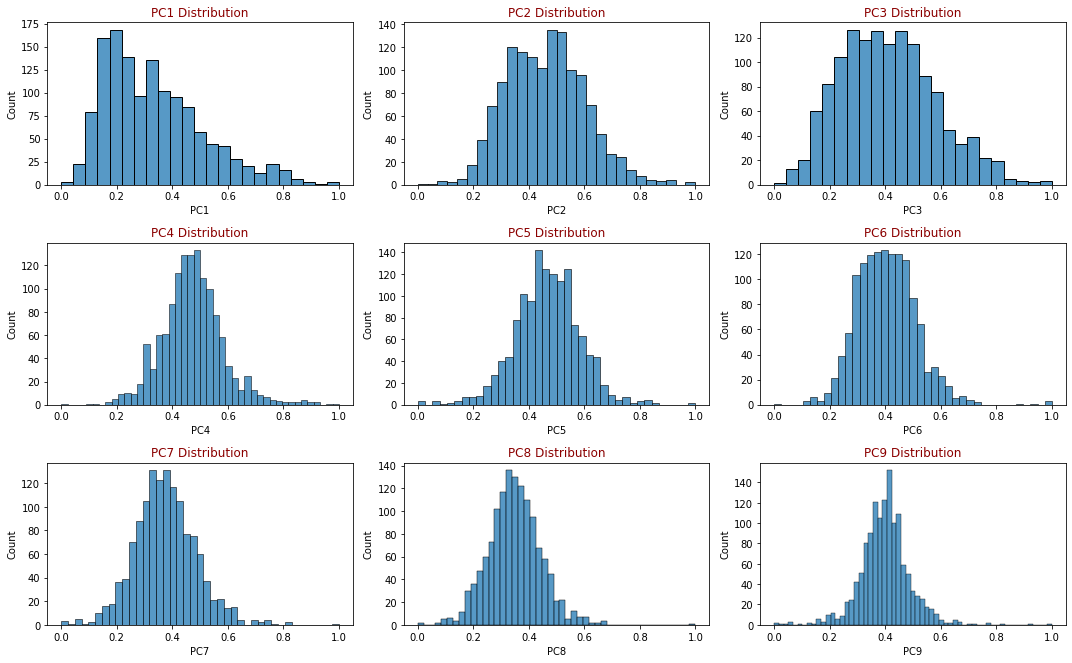

In [ ]:
draw_histograms(norm_data,norm_data.columns,5,3)

From the above visualization it is clear that the data skewness had improved largely after PCA.

We will check the correlation of the dataset now whether any correlated columns left in dataset.

In [ ]:
#get correlations of each features in dataset
corr_matrix = norm_data.corr()
corrPairs = corr_matrix.unstack()
ordPairs = corrPairs.sort_values(kind="quicksort").drop_duplicates()
positivePairs = ordPairs[ordPairs >0.8 ]
positivePairs = positivePairs[ordPairs <1 ]
print(positivePairs)


Series([], dtype: float64)


We can see there is no more correlated columns left.

### Data Preparation 

Selection of training and testing set is done to check our model’s performance on unseen data usually the accuracy which we print for our model is derived on validation set only. We used sklearn’s train_test_split() function to split our data frame to training and testing set.

In [ ]:
from sklearn.model_selection import train_test_split
X=norm_data 
Y=Target

#### Case 1 : Train = 80 % Test = 20% [ x_train1,y_train1] = 80% ; [ x_test1,y_test1] = 20% 

In [ ]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, Y, test_size=0.2, random_state=42)

#### Case 2 : Train = 10 % Test = 90% [ x_train2,y_train2] = 10% ; [ x_test2,y_test2] = 90% 

In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(X, Y, test_size=0.1, random_state=42)

#### Case 3 : Train = 50 % Test = 50% [ x_train3,y_train3] = 50% ; [ x_test3,y_test3] = 50% 

In [ ]:
x_train3, x_test3, y_train3, y_test3 = train_test_split(X, Y, test_size=0.5, random_state=42)

<h2>PART B</h2>

### Model Building 

### Logistic Regression Using gradient descent

#### Model Training CASE 1:

In [ ]:
model1 = LogisticRegression(penalty='l2', solver='saga', max_iter=500)    
LR1=model1.fit( x_train1, y_train1)

#### Checking the Accuracy, F1 score, Recall for CASE 1:

In [ ]:
# Prediction on Train data
y_train_pred1 = LR1.predict( x_train1 ) 

In [ ]:
#Testing the Accuracy, F1 score, Recall of Train data
print('Accuracy: ',accuracy_score(y_train1,y_train_pred1))
print('F1 Score: ',f1_score(y_train1,y_train_pred1))
print('Recall: ',recall_score(y_train1,y_train_pred1))

Accuracy:  0.7098880597014925
F1 Score:  0.7838776928422515
Recall:  0.851963746223565


#### Balancing the data for CASE 1

As the class data is imbalanced (62:37) so we are doing the balancing using SMOT(Synthetic Minority Oversampling Technique, or SMOTE ). We are balancing the dataset by increasing the size of rare samples
Rather than getting rid of abundant samples. 

In [ ]:
x_train1_new,y_train1_new = SMOTE().fit_resample(x_train1,y_train1)
print('Original dataset shape', Counter(y_train1))
print('Resample dataset shape', Counter(y_train1_new))

Original dataset shape Counter({1: 662, 0: 410})
Resample dataset shape Counter({0: 662, 1: 662})


In [ ]:
# Prediction on Train data
model1_new = LogisticRegression(penalty='l2', solver='saga', max_iter=500)    
LR1_new=model1_new.fit( x_train1_new, y_train1_new)
y_train_pred1_new = LR1_new.predict( x_train1_new ) 

print('Accuracy: ',accuracy_score(y_train1_new,y_train_pred1_new))
print('F1 Score: ',f1_score(y_train1_new,y_train_pred1_new))
print('Recall: ',recall_score(y_train1_new,y_train_pred1_new))

Accuracy:  0.6918429003021148
F1 Score:  0.6890243902439024
Recall:  0.6827794561933535


#### Model Training CASE 2:

In [ ]:
model2 = LogisticRegression(max_iter=500)    
LR2=model2.fit( x_train2, y_train2)

#### Checking the Accuracy, F1 score, Recall for CASE 2:

In [ ]:
# Prediction on Train data
y_train_pred2 = LR2.predict( x_train2 ) 

In [ ]:
#Testing the Accuracy, F1 score, Recall of Train data
print('Accuracy: ',accuracy_score(y_train2,y_train_pred2))
print('F1 Score: ',f1_score(y_train2,y_train_pred2))
print('Recall: ',recall_score(y_train2,y_train_pred2))

Accuracy:  0.7106135986733002
F1 Score:  0.7852307692307693
Recall:  0.8495339547270306


#### Balancing the data for CASE 2

In [ ]:
x_train2_new,y_train2_new = SMOTE().fit_resample(x_train2,y_train2)
print('Original dataset shape', Counter(y_train2))
print('Resample dataset shape', Counter(y_train2_new))

Original dataset shape Counter({1: 751, 0: 455})
Resample dataset shape Counter({0: 751, 1: 751})


In [ ]:
# Prediction on Train data
model2_new = LogisticRegression(penalty='l2', solver='saga', max_iter=500)    
LR2_new=model2_new.fit( x_train2_new, y_train2_new)
y_train_pred2_new = LR2_new.predict( x_train2_new ) 

print('Accuracy: ',accuracy_score(y_train2_new,y_train_pred2_new))
print('F1 Score: ',f1_score(y_train2_new,y_train_pred2_new))
print('Recall: ',recall_score(y_train2_new,y_train_pred2_new))

Accuracy:  0.6857523302263648
F1 Score:  0.6823687752355317
Recall:  0.6750998668442078


#### Model Training CASE 3:

In [ ]:
model3 = LogisticRegression(max_iter=500)    
LR3=model3.fit( x_train3, y_train3)

#### Checking the Accuracy, F1 score, Recall for CASE 3:

In [ ]:
# Prediction on Train data
y_train_pred3 = model3.predict( x_train3 ) 

In [ ]:
#Testing the Accuracy, F1 score, Recall of Train data
print('Accuracy: ',accuracy_score(y_train3,y_train_pred3))
print('F1 Score: ',f1_score(y_train3,y_train_pred3))
print('Recall: ',recall_score(y_train3,y_train_pred3))

Accuracy:  0.7119402985074627
F1 Score:  0.7974816369359916
Recall:  0.8837209302325582


#### Balancing the data for CASE 3

In [ ]:
x_train3_new,y_train3_new = SMOTE().fit_resample(x_train3,y_train3)
print('Original dataset shape', Counter(y_train3))
print('Resample dataset shape', Counter(y_train3_new))

Original dataset shape Counter({1: 430, 0: 240})
Resample dataset shape Counter({1: 430, 0: 430})


In [ ]:
# Prediction on Train data
model3_new = LogisticRegression(penalty='l2', solver='saga', max_iter=500)    
LR3_new=model3_new.fit( x_train3_new, y_train3_new)
y_train_pred3_new = LR3_new.predict( x_train3_new ) 

print('Accuracy: ',accuracy_score(y_train3_new,y_train_pred3_new))
print('F1 Score: ',f1_score(y_train3_new,y_train_pred3_new))
print('Recall: ',recall_score(y_train3_new,y_train_pred3_new))

Accuracy:  0.7
F1 Score:  0.693586698337292
Recall:  0.6790697674418604


#### Observation
-We are doing this balancing on all cases but our accuracy didn't improve for training data.

### Justification of using L2 Loss Function in Gradient Descent

The reason to used the L2 Loss function as it tries to  disperse the error terms in all the weights that leads to more accurate customized final models and 
also helps to prevent the problem of overfitting, makes the model more robust, and decreases the complexity of a model and while using the L2 regularization for calculating the loss function in the gradient calculation step, 
the loss function tries to minimize the loss by subtracting it from the average of the data distribution.

We have used the first order Gradient Descent optimization algorithm. This means it only takes into account the first derivative when performing the updates on the parameters.
As our dataset is not large so we haven't explore the other methods of Gradient Descent and its not required.

### Logistic Regression Using maximum likelihood estimate

#### Model Training CASE 1:

In [ ]:
model1_mle = sm.Logit(y_train1,x_train1)
result1 = model1_mle.fit()
result1.summary()

Optimization terminated successfully.
         Current function value: 0.574047
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            TARGET_5Yrs   No. Observations:                 1072
Model:                          Logit   Df Residuals:                     1063
Method:                           MLE   Df Model:                            8
Date:                Sat, 08 Jan 2022   Pseudo R-squ.:                  0.1371
Time:                        04:18:14   Log-Likelihood:                -615.38
converged:                       True   LL-Null:                       -713.16
Covariance Type:            nonrobust   LLR p-value:                 5.517e-38
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1            4.9580      0.468     10.591      0.000       4.040       5.876
PC2           -1.7115      0.506     -3.383      0.001      -2.703      -0.720
PC3           -2.0830      0.412     -5.051      0.000      -2.891      -1.275
PC4           -0.3579      0.600     -0.597      0.551      -1.533       0.817
PC5           -0.3526      0.584     -0.603      0.546      -1.498       0.793
PC6            0.2686      0.632      0.425      0.671      -0.970       1.507
PC7            1.2478      0.592      2.106      0.035       0.087       2.409
PC8           -0.7931      0.694     -1.142      0.253      -2.154       0.568
PC9            1.5325      0.779      1.968      0.049       0.006       3.059
==============================================================================
"""

#### Checking the Accuracy, F1 score, Recall for CASE 1:

In [ ]:
#Prediction on Train data
y_train_pred1_mle = result1.predict(x_train1)
rounded_y_train_pred1_mle = list(map(round, y_train_pred1_mle))

In [ ]:
#Testing the Accuracy, F1 score, Recall of Train data
print('Accuracy: ',accuracy_score(y_train1,rounded_y_train_pred1_mle))
print('F1 Score: ',f1_score(y_train1,rounded_y_train_pred1_mle))
print('Recall: ',recall_score(y_train1,rounded_y_train_pred1_mle))

Accuracy:  0.6930970149253731
F1 Score:  0.7668320340184267
Recall:  0.8172205438066465


#### Balancing the data for CASE 1

In [ ]:
# Prediction on Train data
model1_mle_new = sm.Logit(y_train1_new,x_train1_new)
result1_new = model1_mle_new.fit()
#Prediction on Train data
y_train_pred1_mle_new = result1_new.predict(x_train1_new)
rounded_y_train_pred1_mle_new = list(map(round, y_train_pred1_mle_new))

Optimization terminated successfully.
         Current function value: 0.591248
         Iterations 6


In [ ]:
#Testing the Accuracy, F1 score, Recall of Train data
print('Accuracy: ',accuracy_score(y_train1_new,rounded_y_train_pred1_mle_new))
print('F1 Score: ',f1_score(y_train1_new,rounded_y_train_pred1_mle_new))
print('Recall: ',recall_score(y_train1_new,rounded_y_train_pred1_mle_new))

Accuracy:  0.6842900302114804
F1 Score:  0.6823708206686931
Recall:  0.6782477341389728


#### Model Training CASE 2:

In [ ]:
model2_mle = sm.Logit(y_train2,x_train2)
result2 = model2_mle.fit()
result2.summary()

Optimization terminated successfully.
         Current function value: 0.567449
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            TARGET_5Yrs   No. Observations:                 1206
Model:                          Logit   Df Residuals:                     1197
Method:                           MLE   Df Model:                            8
Date:                Sat, 08 Jan 2022   Pseudo R-squ.:                  0.1438
Time:                        04:17:58   Log-Likelihood:                -684.34
converged:                       True   LL-Null:                       -799.24
Covariance Type:            nonrobust   LLR p-value:                 3.286e-45
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1            5.3133      0.460     11.542      0.000       4.411       6.216
PC2           -1.9386      0.483     -4.015      0.000      -2.885      -0.992
PC3           -1.8319      0.394     -4.655      0.000      -2.603      -1.061
PC4           -0.4145      0.571     -0.726      0.468      -1.533       0.704
PC5           -0.7300      0.562     -1.300      0.194      -1.831       0.371
PC6            0.2351      0.610      0.386      0.700      -0.960       1.430
PC7            1.2470      0.565      2.207      0.027       0.140       2.354
PC8           -0.5836      0.662     -0.882      0.378      -1.881       0.713
PC9            1.6680      0.752      2.218      0.027       0.194       3.142
==============================================================================
"""

#### Checking the Accuracy, F1 score, Recall for CASE 2:

In [ ]:
#Prediction on Train data
y_train_pred2_mle = result2.predict(x_train2)
rounded_y_train_pred2_mle = list(map(round, y_train_pred2_mle))

#Testing the Accuracy, F1 score, Recall of Train data
print('Accuracy: ',accuracy_score(y_train2,rounded_y_train_pred2_mle))
print('F1 Score: ',f1_score(y_train2,rounded_y_train_pred2_mle))
print('Recall: ',recall_score(y_train2,rounded_y_train_pred2_mle))

Accuracy:  0.7014925373134329
F1 Score:  0.7744360902255639
Recall:  0.8229027962716379


#### Balancing the data for CASE 2

In [ ]:
# Prediction on Train data
model2_mle_new = sm.Logit(y_train2_new,x_train2_new)
result2_new = model2_mle_new.fit()
#Prediction on Train data
y_train_pred2_mle_new = result2_new.predict(x_train2_new)
rounded_y_train_pred2_mle_new = list(map(round, y_train_pred2_mle_new))

Optimization terminated successfully.
         Current function value: 0.587898
         Iterations 6


In [ ]:
#Testing the Accuracy, F1 score, Recall of Train data
print('Accuracy: ',accuracy_score(y_train2_new,rounded_y_train_pred2_mle_new))
print('F1 Score: ',f1_score(y_train2_new,rounded_y_train_pred2_mle_new))
print('Recall: ',recall_score(y_train2_new,rounded_y_train_pred2_mle_new))

Accuracy:  0.6857523302263648
F1 Score:  0.6806495263870095
Recall:  0.6697736351531292


#### Model Training CASE 3:

In [ ]:
model3_mle = sm.Logit(y_train3,x_train3)
result3 = model3_mle.fit()
result3.summary()

Optimization terminated successfully.
         Current function value: 0.562123
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            TARGET_5Yrs   No. Observations:                  670
Model:                          Logit   Df Residuals:                      661
Method:                           MLE   Df Model:                            8
Date:                Sat, 08 Jan 2022   Pseudo R-squ.:                  0.1384
Time:                        04:17:58   Log-Likelihood:                -376.62
converged:                       True   LL-Null:                       -437.10
Covariance Type:            nonrobust   LLR p-value:                 2.115e-22
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
PC1            4.5450      0.569      7.991      0.000       3.430       5.660
PC2           -1.3803      0.627     -2.201      0.028      -2.609      -0.151
PC3           -2.7807      0.539     -5.160      0.000      -3.837      -1.724
PC4           -0.2796      0.760     -0.368      0.713      -1.769       1.210
PC5            0.1863      0.771      0.242      0.809      -1.325       1.698
PC6            0.0357      0.844      0.042      0.966      -1.618       1.689
PC7            1.5847      0.742      2.134      0.033       0.130       3.040
PC8           -0.5102      0.851     -0.600      0.549      -2.178       1.158
PC9            1.4031      0.957      1.466      0.143      -0.473       3.279
==============================================================================
"""

#### Checking the Accuracy, F1 score, Recall for CASE 3:

In [ ]:
#Prediction on Train data
y_train_pred3_mle = result3.predict(x_train3)
rounded_y_train_pred3_mle = list(map(round, y_train_pred3_mle))

#Testing the Accuracy, F1 score, Recall of Train data
print('Accuracy: ',accuracy_score(y_train3,rounded_y_train_pred3_mle))
print('F1 Score: ',f1_score(y_train3,rounded_y_train_pred3_mle))
print('Recall: ',recall_score(y_train3,rounded_y_train_pred3_mle))

Accuracy:  0.7059701492537314
F1 Score:  0.7865655471289273
Recall:  0.8441860465116279


#### Balancing the data for CASE 3

In [ ]:
# Prediction on Train data
model3_mle_new = sm.Logit(y_train3_new,x_train3_new)
result3_new = model3_mle_new.fit()
#Prediction on Train data
y_train_pred3_mle_new = result3_new.predict(x_train3_new)
rounded_y_train_pred3_mle_new = list(map(round, y_train_pred3_mle_new))

Optimization terminated successfully.
         Current function value: 0.590688
         Iterations 5


In [ ]:
#Testing the Accuracy, F1 score, Recall of Train data
print('Accuracy: ',accuracy_score(y_train3_new,rounded_y_train_pred3_mle_new))
print('F1 Score: ',f1_score(y_train3_new,rounded_y_train_pred3_mle_new))
print('Recall: ',recall_score(y_train3_new,rounded_y_train_pred3_mle_new))

Accuracy:  0.6988372093023256
F1 Score:  0.6956521739130435
Recall:  0.6883720930232559


#### Observation
-We have done the balancing on all cases of GD and MLE but our accuracy didn't improve for training data.

### Comparison of Results for Gradient Descent & MLE

Logistic Regression  using MLE(Maximum Likelihood estimation) for Case 1 and Case 2 is having better accuracy for training data in compare to Gradient descent.
Whereas for  case 3, accuracy is same for training data using MLE and Gradient Descent

### Performance Evaluation 

### Using Gradient Descent 

#### Prediction for the test data and results for the inference

In [ ]:
# Prediction on Test data for CASE 1
y_test_pred1 = LR1.predict( x_test1 ) 

In [ ]:
# Prediction on Test data for CASE 1
y_test_pred1_new = LR1_new.predict( x_test1 ) 

In [ ]:
# Prediction on Test data for CASE 2
y_test_pred2 = LR2.predict( x_test2 ) 

In [ ]:
# Prediction on Test data for CASE 3
y_test_pred3 = LR3.predict( x_test3 ) 

#### Print Accuracy, Recall, F1 Score and Confusion Matrix for Test data

In [ ]:
#Testing the Accuracy, F1 score, Recall and Confusion Matrix for CASE 1
from sklearn.metrics import confusion_matrix

print('Accuracy: ',accuracy_score(y_test1,y_test_pred1))
print('F1 Score: ',f1_score(y_test1,y_test_pred1))
print('Recall: ',recall_score(y_test1,y_test_pred1))
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test1,y_test_pred1))

Accuracy:  0.7089552238805971
F1 Score:  0.7891891891891892
Recall:  0.863905325443787

Confusion Matrix:
[[ 44  55]
 [ 23 146]]


#### Balancing for CASE 1

In [ ]:
#Testing the Accuracy, F1 score, Recall and Confusion Matrix for CASE 1
from sklearn.metrics import confusion_matrix

print('Accuracy: ',accuracy_score(y_test1,y_test_pred1_new))
print('F1 Score: ',f1_score(y_test1,y_test_pred1_new))
print('Recall: ',recall_score(y_test1,y_test_pred1_new))
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test1,y_test_pred1_new))

Accuracy:  0.7238805970149254
F1 Score:  0.7701863354037266
Recall:  0.7337278106508875

Confusion Matrix:
[[ 70  29]
 [ 45 124]]


In [ ]:
#Testing the Accuracy, F1 score, Recall and Confusion Matrix for CASE 2
from sklearn.metrics import confusion_matrix

print('Accuracy: ',accuracy_score(y_test2,y_test_pred2))
print('F1 Score: ',f1_score(y_test2,y_test_pred2))
print('Recall: ',recall_score(y_test2,y_test_pred2))
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test2,y_test_pred2))

Accuracy:  0.7014925373134329
F1 Score:  0.7727272727272727
Recall:  0.85

Confusion Matrix:
[[26 28]
 [12 68]]


#### Balancing for CASE 2

In [ ]:
# Prediction on Test data for CASE 2
y_test_pred2_new = LR2_new.predict( x_test2 ) 
#Testing the Accuracy, F1 score, Recall and Confusion Matrix for CASE 2
print('Accuracy: ',accuracy_score(y_test2,y_test_pred2_new))
print('F1 Score: ',f1_score(y_test2,y_test_pred2_new))
print('Recall: ',recall_score(y_test2,y_test_pred2_new))
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test2,y_test_pred2_new))

Accuracy:  0.7388059701492538
F1 Score:  0.7712418300653595
Recall:  0.7375

Confusion Matrix:
[[40 14]
 [21 59]]


In [ ]:
#Testing the Accuracy, F1 score, Recall and Confusion Matrix for CASE 3
from sklearn.metrics import confusion_matrix

print('Accuracy: ',accuracy_score(y_test3,y_test_pred3))
print('F1 Score: ',f1_score(y_test3,y_test_pred3))
print('Recall: ',recall_score(y_test3,y_test_pred3))
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test3,y_test_pred3))

Accuracy:  0.6835820895522388
F1 Score:  0.7700650759219089
Recall:  0.885286783042394

Confusion Matrix:
[[103 166]
 [ 46 355]]


#### Balancing for CASE 3

In [ ]:
# Prediction on Test data for CASE 2
y_test_pred3_new = LR3_new.predict( x_test3 ) 
#Testing the Accuracy, F1 score, Recall and Confusion Matrix for CASE 2
print('Accuracy: ',accuracy_score(y_test3,y_test_pred3_new))
print('F1 Score: ',f1_score(y_test3,y_test_pred3_new))
print('Recall: ',recall_score(y_test3,y_test_pred3_new))
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test3,y_test_pred3_new))

Accuracy:  0.691044776119403
F1 Score:  0.7342747111681643
Recall:  0.713216957605985

Confusion Matrix:
[[177  92]
 [115 286]]


#### Observation
-We are doing this balancing on test data and our accuracy has improved for test data.

### Using Maximum Likelihood Estimation

#### Prediction for the test data and results for the inference

In [ ]:
# Prediction on Test data for CASE 1
y_test_pred1_mle = result1.predict( x_test1 ) 
rounded_y_test_pred1_mle = list(map(round, y_test_pred1_mle))

In [ ]:
# Prediction on Test data for CASE 2
y_test_pred2_mle = result2.predict( x_test2 ) 
rounded_y_test_pred2_mle = list(map(round, y_test_pred2_mle))

In [ ]:
# Prediction on Test data for CASE 3
y_test_pred3_mle = result3.predict( x_test3 ) 
rounded_y_test_pred3_mle = list(map(round, y_test_pred3_mle))

#### Print Accuracy, Recall, F1 Score and Confusion Matrix for Test data

In [ ]:
#Testing the Accuracy, F1 score, Recall and Confusion Matrix for CASE 1
print('Accuracy: ',accuracy_score(y_test1,rounded_y_test_pred1_mle))
print('F1 Score: ',f1_score(y_test1,rounded_y_test_pred1_mle))
print('Recall: ',recall_score(y_test1,rounded_y_test_pred1_mle))
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test1,rounded_y_test_pred1_mle))

Accuracy:  0.7201492537313433
F1 Score:  0.7910863509749303
Recall:  0.8402366863905325

Confusion Matrix:
[[ 51  48]
 [ 27 142]]


#### Balancing on CASE 1

In [ ]:
# Prediction on Test data for CASE 1
y_test_pred1_mle_new = result1_new.predict( x_test1 ) 
rounded_y_test_pred1_mle_new = list(map(round, y_test_pred1_mle_new))
#Testing the Accuracy, F1 score, Recall and Confusion Matrix for CASE 1
print('Accuracy: ',accuracy_score(y_test1,rounded_y_test_pred1_mle_new))
print('F1 Score: ',f1_score(y_test1,rounded_y_test_pred1_mle_new))
print('Recall: ',recall_score(y_test1,rounded_y_test_pred1_mle_new))
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test1,rounded_y_test_pred1_mle_new))

Accuracy:  0.7238805970149254
F1 Score:  0.7716049382716049
Recall:  0.7396449704142012

Confusion Matrix:
[[ 69  30]
 [ 44 125]]


In [ ]:
#Testing the Accuracy, F1 score, Recall and Confusion Matrix for CASE 2
print('Accuracy: ',accuracy_score(y_test2,rounded_y_test_pred2_mle))
print('F1 Score: ',f1_score(y_test2,rounded_y_test_pred2_mle))
print('Recall: ',recall_score(y_test2,rounded_y_test_pred2_mle))
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test2,rounded_y_test_pred2_mle))

Accuracy:  0.7238805970149254
F1 Score:  0.7836257309941521
Recall:  0.8375

Confusion Matrix:
[[30 24]
 [13 67]]


#### Balancing on CASE 2

In [ ]:
# Prediction on Test data for CASE 2
y_test_pred2_mle_new = result2_new.predict( x_test2 ) 
rounded_y_test_pred2_mle_new = list(map(round, y_test_pred2_mle_new))
#Testing the Accuracy, F1 score, Recall and Confusion Matrix for CASE 1
print('Accuracy: ',accuracy_score(y_test2,rounded_y_test_pred2_mle_new))
print('F1 Score: ',f1_score(y_test2,rounded_y_test_pred2_mle_new))
print('Recall: ',recall_score(y_test2,rounded_y_test_pred2_mle_new))
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test2,rounded_y_test_pred2_mle_new))

Accuracy:  0.7388059701492538
F1 Score:  0.7682119205298014
Recall:  0.725

Confusion Matrix:
[[41 13]
 [22 58]]


In [ ]:
#Testing the Accuracy, F1 score, Recall and Confusion Matrix for CASE 3
print('Accuracy: ',accuracy_score(y_test3,rounded_y_test_pred3_mle))
print('F1 Score: ',f1_score(y_test3,rounded_y_test_pred3_mle))
print('Recall: ',recall_score(y_test3,rounded_y_test_pred3_mle))
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test3,rounded_y_test_pred3_mle))

Accuracy:  0.6925373134328359
F1 Score:  0.7700892857142858
Recall:  0.8603491271820449

Confusion Matrix:
[[119 150]
 [ 56 345]]


#### Balancing on CASE 3

In [ ]:
# Prediction on Test data for CASE 2
y_test_pred3_mle_new = result3_new.predict( x_test3 ) 
rounded_y_test_pred3_mle_new = list(map(round, y_test_pred3_mle_new))
#Testing the Accuracy, F1 score, Recall and Confusion Matrix for CASE 1
print('Accuracy: ',accuracy_score(y_test3,rounded_y_test_pred3_mle_new))
print('F1 Score: ',f1_score(y_test3,rounded_y_test_pred3_mle_new))
print('Recall: ',recall_score(y_test3,rounded_y_test_pred3_mle_new))
print()
print('Confusion Matrix:')
print(confusion_matrix(y_test3,rounded_y_test_pred3_mle_new))

Accuracy:  0.6940298507462687
F1 Score:  0.736842105263158
Recall:  0.71571072319202

Confusion Matrix:
[[178  91]
 [114 287]]


#### Observation
-We are doing this balancing on test data and our accuracy has improved for test data.

#### Comparison of the Accuracy of Train and Test data

In [ ]:
print('============================================')
print('Train Accuracy GD Case 1: ',accuracy_score(y_train1,y_train_pred1))
print('Test Accuracy GD Case 1: ',accuracy_score(y_test1,y_test_pred1))
print('============================================')

print('Train Accuracy GD Case 2: ',accuracy_score(y_train2,y_train_pred2))
print('Test Accuracy GD Case 2: ',accuracy_score(y_test2,y_test_pred2))
print('============================================')

print('Train Accuracy GD Case 3: ',accuracy_score(y_train3,y_train_pred3))
print('Test Accuracy GD Case 3: ',accuracy_score(y_test3,y_test_pred3))
print('============================================')
print('Train Accuracy MLE Case 1: ',accuracy_score(y_train1,rounded_y_train_pred1_mle))
print('Test Accuracy MLE Case 1: ',accuracy_score(y_test1,rounded_y_test_pred1_mle))
print('============================================')
print('Train Accuracy MLE Case 2: ',accuracy_score(y_train2,rounded_y_train_pred2_mle))
print('Test Accuracy MLE Case 2: ',accuracy_score(y_test2,rounded_y_test_pred2_mle))
print('============================================')
print('Train Accuracy MLE Case 3: ',accuracy_score(y_train3,rounded_y_train_pred3_mle))
print('Test Accuracy MLE Case 3: ',accuracy_score(y_test3,rounded_y_test_pred3_mle))
print('============================================')

Train Accuracy GD Case 1:  0.7098880597014925
Test Accuracy GD Case 1:  0.7089552238805971
Train Accuracy GD Case 2:  0.7106135986733002
Test Accuracy GD Case 2:  0.7014925373134329
Train Accuracy GD Case 3:  0.7119402985074627
Test Accuracy GD Case 3:  0.6835820895522388
Train Accuracy MLE Case 1:  0.6930970149253731
Test Accuracy MLE Case 1:  0.7201492537313433
Train Accuracy MLE Case 2:  0.7014925373134329
Test Accuracy MLE Case 2:  0.7238805970149254
Train Accuracy MLE Case 3:  0.7059701492537314
Test Accuracy MLE Case 3:  0.6925373134328359


### Visualization of Performances

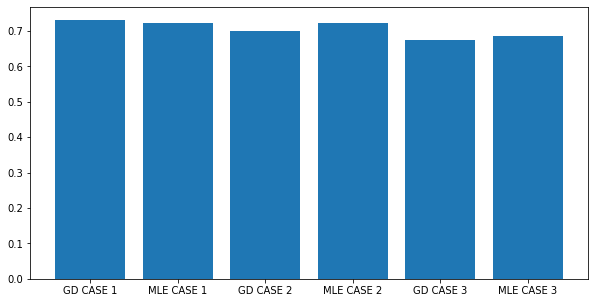

In [ ]:
names = ['GD CASE 1','MLE CASE 1','GD CASE 2','MLE CASE 2','GD CASE 3','MLE CASE 3']
values = [0.7313,0.7238,0.7014,0.7238,0.6746, 0.6865]
f = plt.figure(figsize=(10,5),num=10)

plt.bar(names,values)
plt.show()

### Analysis for All Cases

Logistic Regression using Gradient descent for Case 1 is having better test accuracy than MLE(Maximum Likelihood estimation).
Whereas for case 2 and case 3, test accuracy is better for MLE in compared to Gradient Descent

### Observation

**CASE 1**

-Accuracy for test data is better by using Gradient Descent in compared to Maximum Likelihood Estimation

**CASE 2**

-Accuracy for test data is better by using Maximum Likelihood Estimation in compared to Gradient Descent


**CASE 3**

-Accuracy for test data is better by using Maximum Likelihood Estimation in compared to Gradient Descent
